In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

/Users/muddy_flesh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Consider the Ising spins with $S_i = \pm 1$ on the site $i$ of square lattice $L^d$, The system $Hamiltonian$ is:
$$
\mathcal{H} = - \sum_{<i,j>}J_{i,j}S_iS_j
$$
$J_{i,j}$ is the coupling between sites $i$ and $j$. For the Edward-Anderson (EA) Model considered here, $J_{i,j}$ has a Gaussian distribution with mean 0 and variance 1.

For the initial configuration of the system, we let each spin having $\frac{1}{2}$ probability to be $1$ and $\frac{1}{2}$ probability to be $-1$, corresponding to temperature $T = \infin$. We let the system follow the $Glauber Dynamics$: each time, a spin $S_i$ is randomly chosen, and we calculate the change in energy $\Delta E$ if we flip the spin. If $\Delta E < 0$, we flip the spin, and otherwise we don't (note that normally when $\Delta E = 0$, it will have a probability of $\frac{1}{2} to flip, however since we are taking continuous distribution of coupling $J_{i,j}$ here, meaning this event can't happen). We keep on running this process until we reach the ground state, meaning there is no spins to flip.

In [3]:
### Note that different pairs of spins should have different bonds
### Hence we use dictionary as the implementation for the bonds
### However the order in the pair doesn't matter, hence we use frozenset as the keys for dictionary
def get_bound_EA(index1, index2, bonds):
    bond = frozenset({tuple(index1),tuple(index2)})
    if bond in bonds:
        return bonds[bond]
    else:
        bonds[bond] = np.random.standard_normal()
        return bonds[bond]

In [1]:
bonds = dict()

In [4]:
def increase_entry_by_one(A, j):
    A_modified = A.copy()
    A_modified[j] += 1
    return A_modified

In [5]:
def decrease_entry_by_one(A, j):
    A_modified = A.copy()
    A_modified[j] -= 1
    return A_modified

In [6]:
def get_neighbor(indices,L):
    neighbor_index = []
    for j in range(len(indices)):
        if (indices[j] == 0):
            neighbor_index.append(increase_entry_by_one(indices, j))
            indice_copy = indices.copy()
            indice_copy[j] = L-1
            neighbor_index.append(indice_copy)
        elif (indices[j] == L-1):
            neighbor_index.append(decrease_entry_by_one(indices, j))
            indice_copy = indices.copy()
            indice_copy[j] = 0
            neighbor_index.append(indice_copy)
        else:
            neighbor_index.append(increase_entry_by_one(indices, j))
            neighbor_index.append(decrease_entry_by_one(indices, j))
    return neighbor_index

In [7]:
def get_energy(spin, spin_index, neighbor_index, S):
    energy = 0
    for neighbor in neighbor_index:
        bond = get_bound_EA(spin_index, neighbor, bonds)
        energy = energy + bond*spin*S[tuple(neighbor)]
    return energy

The basic idea here is that we are having two Ising System $I_1$ and $I_2$, sharing the same initial configuration. We then let both of them go through the Glauber Dynamics, to track their overlap, we define it as:
$$
q_t(N) = \frac{1}{N}\sum_{i}^N S_i^{1}(t)S_i^{2}(t),
$$
where $N = L^d$ and $t$ is the time measured by the sweeps. We define each flip attempt to be $\frac{1}{N}$ sweep, so that for each sweep we can averagely flip the whole system. Obviously, when $t = 0$, their overlap is $1$, but as the dynamic goes on, their overlap decreases.

In [8]:
def overlap(S1,S2,N):
    return np.sum(S1*S2)/N

def sweep(S,L,N):
    sweep = 0
    while sweep < N:
        indices = [np.random.choice(dim) for dim in S.shape]
        spin = S[tuple(indices)]
        neighbor_index = get_neighbor(indices,L)
        beforeE = get_energy(spin, indices, neighbor_index, S)
        afterE = get_energy(-spin, indices, neighbor_index, S)
        deltaE = afterE - beforeE
        if deltaE > 0:
            S[tuple(indices)] = -spin
        sweep = sweep+1

In [9]:
def is_active(index, S, L):
    spin = S[tuple(index)]
    neighbor_index = get_neighbor(np.asarray(index),L)
    beforeE = get_energy(spin, index, neighbor_index, S)
    afterE = get_energy(-spin, index, neighbor_index, S)
    deltaE = afterE - beforeE
    return deltaE > 0

In [10]:
def get_active(S,L):
    it = np.nditer(S,flags = ['multi_index'])
    active_indices = []
    while not it.finished:
        index = it.multi_index
        if is_active(index, S, L):
            active_indices.append(index)
        it.iternext()
    return active_indices

After a number of sweeps, the list of spins that are still active to flip is actually relatively small. We can therefore use Kinetic Monte Carlo Method to speed up the running time: we set a list of active spins, and for each flip attempt, we only look at the spins in the active list, only this time we update $t$ by $\frac{1}{f_t(N)}$, where $f_t(N)$ here is the size of the active list. After each flip, we remove the flipped spin, and check its neighbors whether they will be added or removed from the active list.

In [ ]:
import random

def kineticMonteCarlo(S,L,active_list):
    l = len(active_list)
    if l == 0:
        return 0
    t = 1/l
    index = random.choice(active_list)
    spin = S[tuple(index)]
    neighbor_index = get_neighbor(np.asarray(index),L)
    beforeE = get_energy(spin, index, neighbor_index, S)
    afterE = get_energy(-spin, index, neighbor_index, S)
    deltaE = afterE - beforeE
    if deltaE > 0:
        S[tuple(index)] = -spin
        active_list.remove(tuple(index))
        for nspin in neighbor_index:
            if is_active(nspin,S,L):
                if not (tuple(nspin) in active_list):
                    active_list.append(tuple(nspin))
            else:
                if (tuple(nspin) in active_list):
                    active_list.remove(tuple(nspin))
    return t

In [11]:
length = 100
dimension = 2
N = length ** dimension
model = 'EA'
config = np.random.choice([-1, 1], size=tuple([length] * dimension))
S2 = config.copy()
S1 = config.copy()

1.0


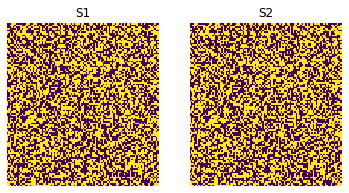

In [12]:
figure = plt.figure(figsize=(6, 3))
figure.add_subplot(1, 2, 1)
plt.title('S1')
plt.axis("off")
plt.pcolor(S1)
figure.add_subplot(1, 2, 2)
plt.title('S2')
plt.axis("off")
plt.pcolor(S2)
print(overlap(S1,S2,N))

In [13]:
survival1 = 0
survival2 = 0
while len(get_active(S1,length)) != 0:
    sweep(S1,length,N)
    survival1 = survival1 + 1
while len(get_active(S2,length)) != 0:
    sweep(S2,length,N)
    survival2 = survival2 + 1

In [14]:
overlap(S1,S2,N)

0.4226

In [15]:
survival1

13

In [16]:
survival2

13